In [1]:
%load_ext autoreload
%autoreload 2
%run ~/FKMC/notebooks/notebook_preamble.py
%matplotlib inline
np.seterr(under = 'ignore')

Imported pathlib::Path, os, munch::Munch, pickle, logging, itertools::count, matplotlib::colors
Names are pyplot = plt, matplotlib = mpl, numpy = np


{'divide': 'warn', 'over': 'warn', 'under': 'warn', 'invalid': 'warn'}

## Goals for this notebook


* stop plotting IPR where the DOS is too low to give it a value 
* Do a sanity check, does my IPR scaling code show all the states being localised at infinite temperature. Does changing U from a gappless to a gapped state affect this.
* Compare to the MCMC results.

### Sanity check at infinite temperature

In [2]:
from FKMC.general import interaction_matrix, solve_H_vectorised, shapes
from FKMC.general import index_histogram_array, sort_IPRs, normalise_IPR, smooth, get_nearby_index, spread
from time import time
from FKMC.general import scaling_dimension


def solve(states, params, energy_histogram_bins, scale = 0.5):
    params.J_matrix = interaction_matrix(**params)
    N = states.shape[-1]

    #NB the states argument should have only 1s and 0s
    #Fc is infinite at infinite temperature
    Ff, Fc, eigenvals, eigenvecs = solve_H_vectorised(states, **params)

    #calculate the IPR measure
    IPR_raw_values = ((eigenvecs * np.conj(eigenvecs))**2).sum(axis = -2)

    #take lists of IPR and eigenvalues and bin them into histograms
    DOS, _, sorting_indices = index_histogram_array(energy_histogram_bins, eigenvals)
    IPR = sort_IPRs(sorting_indices, IPR_raw_values, energy_histogram_bins)

    DOS, dDOS = DOS.mean(axis = 0), scipy.stats.sem(DOS, axis = 0)
    IPR, dIPR = IPR.mean(axis = 0), scipy.stats.sem(IPR, axis = 0)

    #divide IPR by DOS without incurring divide by errors where DOS = 0, set IPR = 0 there too
    DOS, IPR = normalise_IPR(DOS, IPR)
    _, dIPR = normalise_IPR(DOS, dIPR)

    #smooth out the spikey values and normalise DOS by system size
    DOS = smooth(DOS, scale = scale, axis = -1)
    dDOS = smooth(dDOS, scale = scale, axis = -1)
    
    IPR = smooth(IPR, scale = scale, axis = -1)
    dIPR = smooth(dIPR, scale = scale, axis = -1)
    
    #take a threshold on DOS
    insufficient_data = (DOS < 1)
    
    #mask out IPR where the DOS is too low
    #IPR = np.ma.masked_where(insufficient_data, IPR)
    #dIPR = np.ma.masked_where(insufficient_data, dIPR)
    
    DOS, dDOS = DOS/N, dDOS/N
    
    return DOS, IPR, dDOS, dIPR

print(f'Computing the infT limit')

def infinite_T(Us, Ns, N_eigenstates = 1e4):
    os = [None for _ in Us]
    for i,U in zip(count(), Us):
        t = time()
        o = Munch()
        os[i] = o
        o.N_eigenstates = int(N_eigenstates) # do states / N disorder realisations
        o.Ns = Ns# system sizes
        o.Ts = np.array([np.infty,])
        o.t = 1
        o.U = U
        o.J = 500
        o.spread_IPR = False

        o.energy_histogram_bins = np.linspace(-6*o.U, 6*o.U, 10000)
        shape = (4, len(o.Ns), 1, len(o.energy_histogram_bins)-1)
        o.DOS, o.IPR, o.dDOS, o.dIPR = np.nan * np.zeros(shape = shape)

        for i,N in zip(count(), o.Ns):
            M = o.N_eigenstates // N + 1 # Number of Disorder_realisations
            states = np.random.choice([1,0], size = (M,N)) #take 50-50 uncorrelated coin flips to simulate infinite temp limit.
            o.parameters = Munch(mu=0.0, beta = np.nan, U = o.U, t = o.t, N = N, alpha = 1.25, J = o.J)
            o.DOS[i], o.IPR[i], o.dDOS[i], o.dIPR[i] = solve(states, o.parameters, scale = 0.5, energy_histogram_bins = o.energy_histogram_bins)

        o.hints = Munch()
        for name in ['DOS', 'IPR', 'dIPR', 'dDOS']: o.hints[name] = ('Ns', 'Ts', 'energy')
        print(f'U = {U} done in {time() - t:.0f}s')
    return os
    

Computing the infT limit


In [3]:
Ns = np.logspace(np.log10(35), np.log10(250), 10, dtype = np.int) // 5 * 5
Ns

array([ 35,  40,  50,  65,  80, 100, 125, 160, 200, 245])

In [4]:
Us = np.array([0.5,1,1.5,2,5,10,30])
Ns = np.logspace(np.log10(30), np.log10(350), 10, dtype = np.int) // 5 * 5
print('Ns = ', Ns)
print('logNs = ', np.log(Ns))
os = infinite_T(Us, Ns, N_eigenstates = 1e5)
print('Done')

Ns =  [ 25  35  50  65  85 115 150 200 265 350]
logNs =  [3.21887582 3.55534806 3.91202301 4.17438727 4.44265126 4.74493213
 5.01063529 5.29831737 5.57972983 5.85793315]
U = 0.5 done in 14s
U = 1.0 done in 14s
U = 1.5 done in 14s
U = 2.0 done in 14s
U = 5.0 done in 14s
U = 10.0 done in 14s
U = 30.0 done in 14s
Done


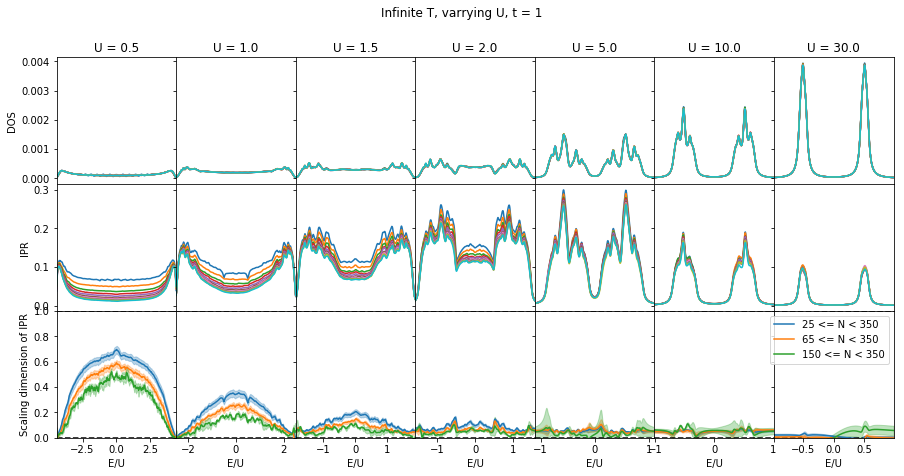

In [12]:
def plot_scaling_dimension(axes, o, T_i, spread_IPR = False, cutoffs = [0,], DOS_cutoff = 0.001):
    #print(" ".join(f'{k}={v}' for k,v in o.parameters.items() if k != 'J_matrix'))
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    Eidx = (o.DOS[-1, T_i] * o.Ns[-1]) < DOS_cutoff #region of insufficient data
    Erange = o.energy_histogram_bins[1:][~Eidx] / o.parameters.U
    Emin, Emax = np.min(Erange), np.max(Erange)
    
    for i,N in zip(count(), o.Ns):
        IPR = o.IPR[i, T_i].copy()
        IPR[Eidx] = np.NaN
        #compute the bounds of the IPR that gets plotted
        
        axes[0].plot(o.energy_histogram_bins[1:] / o.parameters.U, o.DOS[i, T_i], label = f'N = {N}', color = colors[i])
        if spread_IPR:
            spread(axes[1], o.energy_histogram_bins[1:] / o.parameters.U, IPR, o.dIPR[i, T_i], color = colors[i])
        else:    
            axes[1].plot(o.energy_histogram_bins[1:] / o.parameters.U, IPR, color = colors[i])

        axes[0].set(xlim = (Emin, Emax))

    
    try:
        for cutoff in cutoffs:
            idx = (o.Ns >= cutoff)
            m, c, dm, dc = scaling_dimension(o.Ns[idx], o.IPR[idx, T_i], o.dIPR[idx, T_i], use_true_errors = True)
            m[Eidx] = np.NaN
            spread(axes[2], o.energy_histogram_bins[1:] / o.parameters.U, -m, dm, label = f'{cutoff} <= N < {max(o.Ns)}')

    except scipy.linalg.LinAlgError:
        pass


    xlim = axes[2].get_xlim()
    axes[2].hlines([0,1], xmin = xlim[0], xmax = xlim[1], linestyles = 'dashed')

    
f, axes = plt.subplots(3,len(Us), figsize = (15,7), 
                       sharex = 'col', 
                       sharey = 'row',
                      gridspec_kw = dict(wspace = 0, hspace = 0),
                      )

T_i = 0
axes[2,0].set(ylabel = 'Scaling dimension of IPR', ylim = (0,1))
axes[0,0].set(ylabel = 'DOS')    
axes[1,0].set(ylabel = 'IPR', yscale = 'linear')

for a in axes[2, :]: a.set(xlabel = 'E/U')
    
for i, U in zip(count(), Us):
    axes.T[i,0].set(title = f'U = {U}')
    plot_scaling_dimension(axes.T[i], os[i], T_i, cutoffs = [min(os[i].Ns), 65, 150], DOS_cutoff = 0.01)
    
#axes[0,0].legend();
axes[2,-1].legend();
f.suptitle('Infinite T, varrying U, t = 1');

### Parameters: U varrying, T = infinity, t = 1, J and $\alpha$ don't affect the spectrum at infinite T

The above infitinite T limit is very similar to Anderson localisation except with binary disorder instead of disorder from a uniform distribution. With Anderson disorder, 1 and 2D systems should be localised at all disorder strengths. However this could be a finite size effect caused by the localisation length being larger than the system at small U. 

This is a fit of the form 
$$IPR(N, E) = A \cdot N ^{-m}$$
$$ log(IPR) = log(A) - m log(N) $$

for free parameters A and m and I'm calling m the 'Scaling dimension of the IPR' because it is equal to the lattice dimension for delocalised states. 

I tried calculating the IPR scaling with some of the smaller system sizes ommited, this doesn't seem to make a huge difference. 

I think this is because to do a fit to this you want log(N) to be evenly spaced, which means N needs to increase exponentially to get reasoably good fits. 

All of which suggests to me that to use IPR scaling like measures in the long localisation length regime, you need both large system sizes and an exponentially distributed range of them, that makes the computational effort required very high. 

The idea that it's the localisation length being longer than the system size fits with the Weakly localised regime that is found in the 2D model https://arxiv.org/pdf/1605.01390.pdf

![alt text](2dPD.png "Title")


In [6]:
## multi T mutli U data
from FKMC.import_funcs import get_data_structured, get_data_funcmap, mean_over_MCMC, IPRandDOS
def load(i): 
    p = Path(f'/workspace/tch14/slurm_runs_scratch/{i}')
    return get_data_funcmap(p,
                functions = [IPRandDOS(E_bins = np.linspace(-40, 40, 5000 + 1)), mean_over_MCMC('Mf_moments')],
                structure_names = ('repeats','Us','Ts'),
               )

logger = logging.getLogger('FKMC.import_funcs')
logger.setLevel(logging.INFO) 
jobid = 154259
multiUT = load(jobid)
with open(f'/workspace/tch14/pickled_data/{jobid}_processed.pickle', 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(multiUT, f, pickle.HIGHEST_PROTOCOL)
    print('Pickling Successful')

CRITICAL:FKMC.import_funcs:looking in /workspace/tch14/slurm_runs_scratch/154259
INFO:FKMC.import_funcs:job ids range from 0 to 279
INFO:FKMC.import_funcs:structure_names = ('repeats', 'Us', 'Ts')
INFO:FKMC.import_funcs:structure_dims = (array(5), 7, 8)
INFO:FKMC.import_funcs:Expected number of jobs 280
INFO:FKMC.import_funcs:Logger keys: ['total_jobs', 'Us', 'Ts', 'Ns', 'repeats', 'structure_names', 'parameters', 'MCMC_params', 'logs', 'desc'] 

INFO:FKMC.import_funcs:MCMC_params: Munch({'state': array([0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0.,
       0., 1., 0., 1., 1., 0., 1., 1., 0., 0., 1., 1., 1., 0., 1., 1., 1.,
       0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 0., 1.,
       1., 1., 0., 1., 1., 0., 0., 0., 1., 1., 1., 0., 1., 1., 0., 0., 1.,
       0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 0., 1., 0., 1., 0., 0., 1.,
       1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 1., 0.,
       0., 1., 0., 0., 0., 1., 0., 1., 1., 1., 

In [7]:
from munch import munchify
from FKMC.general import smooth, spread
from scipy.stats import sem

#this data has was preprocessed and saved in munich/Figures/Data_preparation_for_linear_T_plots.ipynb
#gatherered using get_data_funcmap so IPR is normalised by DOS
with open(f'/workspace/tch14/pickled_data/{jobid}_processed.pickle', 'rb') as file: 
    o = multiUT = munchify(pickle.load(file))
    
print(f"Keys available in long range data: {o.keys()}")

print("Hamiltionian params for the Long Range data:")
o.parameters.beta = "Variable"
print(", ".join(f"{k} = {v}" for k,v in o.parameters.items()))
print('\n')

print("Simulation params for the Long Range data:")
print(o.MCMC_params)

print('\nShape hint for o.IPR')
print(o.hints.DOS)
print(o.DOS.shape)
    
o.energy_histogram_bins = o.E_bins

#pluck out particular Ns and starting states
Nmask = (o.Ns > 8)
o.Ns = o.Ns[Nmask]
print(o.Ns, Nmask)
for name in ['DOS', 'dDOS', 'IPR', 'dIPR']:
    o[name] = o[name][Nmask]
    #o[name] = o[name][:, :, [0,1,2]] #get particular starting states

axis = (1,) #mean out the repeat and starting states axes
print(f'Taking mean over axes {axis} which are {np.array(o.hints.DOS)[axis,]}')

#use the indepedant repeats to estimate the errors
#o.DOS, o.dDOS = o.DOS.mean(axis = axis), sem(o.DOS.mean(axis = 3), axis = 2)
#o.IPR, o.dIPR = o.IPR.mean(axis = axis), sem(o.IPR.mean(axis = 3), axis = 2)

#use binning over the mcmc steps to estimate the errors
o.DOS, o.dDOS = o.DOS.mean(axis = axis), o.dDOS.mean(axis = axis)
o.IPR, o.dIPR = o.IPR.mean(axis = axis), o.dIPR.mean(axis = axis)

print('\nShape of o.DOS after mean')
print("Should be ('Ns', 'Us', 'Ts', 'energy index')")
print(o.DOS.shape)

#('Ns', 'Ts', 'energy index')

#smooth them
for i, N in zip(count(), o.Ns):
    o.DOS[i] = smooth(o.DOS[i], scale = 32 / N) / N
    o.IPR[i] = smooth(o.IPR[i], scale = 32 / N)

    o.dDOS[i] = smooth(o.dDOS[i], scale = 32 / N) / N
    o.dIPR[i] = smooth(o.dIPR[i], scale = 32 / N)
    
print('Loaded data for Long Range IPR and DOS as a function of T')

Keys available in long range data: dict_keys(['E_bins', 'IPR', 'DOS', 'dIPR', 'dDOS', 'Mf_moments', 'sigma_Mf_moments', 'total_jobs', 'Us', 'Ts', 'Ns', 'repeats', 'structure_names', 'parameters', 'MCMC_params', 'desc', 'structure_dims', 'hints', 'T'])
Hamiltionian params for the Long Range data:
t = 1, alpha = 1.25, mu = 0, beta = Variable, J = 5, U = 0.5, normalise = True, N_sites = 150, J_matrix = [[ 0.          0.74516288 -0.31338831 ...  0.18887183 -0.31338831
   0.74516288]
 [ 0.74516288  0.          0.74516288 ... -0.13190817  0.18887183
  -0.31338831]
 [-0.31338831  0.74516288  0.         ...  0.099883   -0.13190817
   0.18887183]
 ...
 [ 0.18887183 -0.13190817  0.099883   ...  0.          0.74516288
  -0.31338831]
 [-0.31338831  0.18887183 -0.13190817 ...  0.74516288  0.
   0.74516288]
 [ 0.74516288 -0.31338831  0.18887183 ... -0.31338831  0.74516288
   0.        ]]


Simulation params for the Long Range data:
Munch({'state': array([0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 0., 0

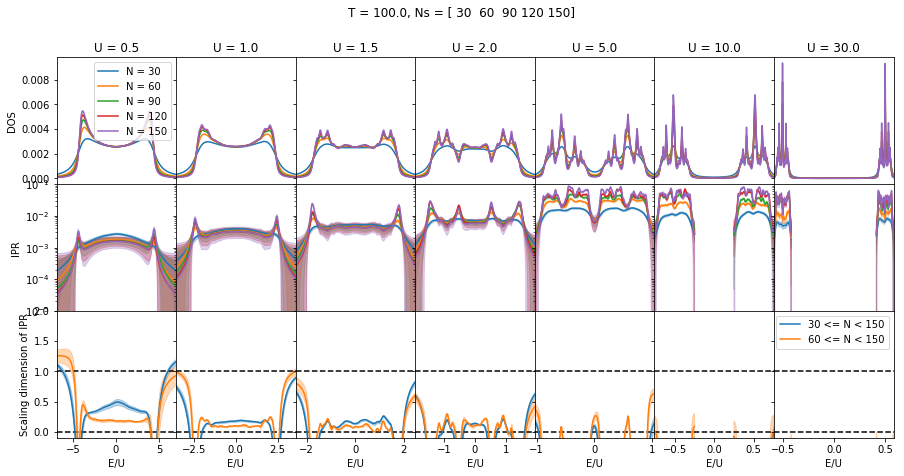

In [8]:
f, axes = plt.subplots(3,len(Us), figsize = (15,7), 
                       sharex = 'col', sharey = 'row',
                      gridspec_kw = dict(wspace = 0, hspace = 0),
                      )


T_i = 0
T = multiUT.Ts[T_i]

axes[2,0].set(ylabel = 'Scaling dimension of IPR', ylim = (0,1))
axes[0,0].set(ylabel = 'DOS')    
axes[1,0].set(ylabel = 'IPR', yscale = 'log')

for a in axes[2, :]: a.set(xlabel = 'E/U')
    
for i, U in zip(count(), multiUT.Us):
    axes.T[i,0].set(title = f'U = {U}')
    o = Munch()
    for name in ['parameters','energy_histogram_bins', 'Ns']: o[name] = multiUT[name]
    for name in ['DOS','dDOS','IPR','dIPR']: o[name] = multiUT[name][:, i] #pull out the choice of U
    o.parameters.U = U
    
    plot_scaling_dimension(axes.T[i], o, T_i, cutoffs = [30, 60], spread_IPR = True, DOS_cutoff = 0.01)
    
    
#for a in axes[2, :]: a.set(xlim = (-5,5))
axes[1, 0].set(ylim = (1e-5,1e-1))
axes[2, 0].set(ylim = (-0.1,2))
axes[0,0].legend();
f.suptitle(f'T = {T}, Ns = {multiUT.Ns}')
axes[2,-1].legend();

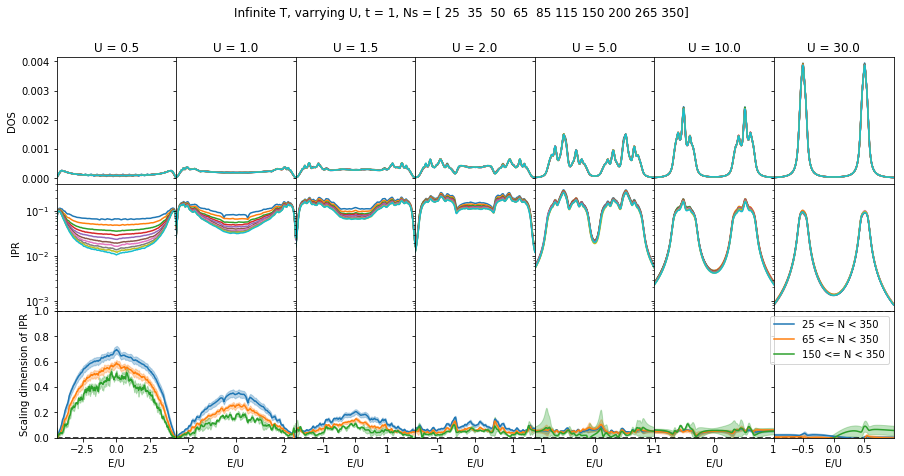

In [9]:
f, axes = plt.subplots(3,len(Us), figsize = (15,7), 
                       sharex = 'col', 
                       sharey = 'row',
                      gridspec_kw = dict(wspace = 0, hspace = 0),
                      )

T_i = 0
axes[2,0].set(ylabel = 'Scaling dimension of IPR', ylim = (0,1))
axes[0,0].set(ylabel = 'DOS')    
axes[1,0].set(ylabel = 'IPR', yscale = 'log')

for a in axes[2, :]: a.set(xlabel = 'E/U')
    
for i, U in zip(count(), Us):
    axes.T[i,0].set(title = f'U = {U}')
    plot_scaling_dimension(axes.T[i], os[i], T_i, cutoffs = [min(os[i].Ns), 65, 150], DOS_cutoff = 0.01)
    
#axes[0,0].legend();
axes[2,-1].legend();
f.suptitle(f'Infinite T, varrying U, t = 1, Ns = {os[i].Ns}');

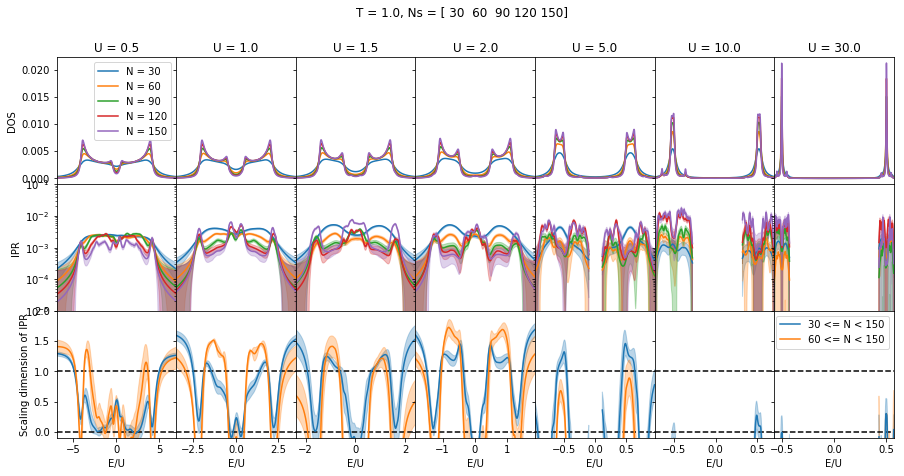

In [10]:
f, axes = plt.subplots(3,len(Us), figsize = (15,7), 
                       sharex = 'col', sharey = 'row',
                      gridspec_kw = dict(wspace = 0, hspace = 0),
                      )


T_i = -2
T = multiUT.Ts[T_i]

axes[2,0].set(ylabel = 'Scaling dimension of IPR', ylim = (0,1))
axes[0,0].set(ylabel = 'DOS')    
axes[1,0].set(ylabel = 'IPR', yscale = 'log')

for a in axes[2, :]: a.set(xlabel = 'E/U')
    
for i, U in zip(count(), multiUT.Us):
    axes.T[i,0].set(title = f'U = {U}')
    o = Munch()
    for name in ['parameters','energy_histogram_bins', 'Ns']: o[name] = multiUT[name]
    for name in ['DOS','dDOS','IPR','dIPR']: o[name] = multiUT[name][:, i] #pull out the choice of U
    o.parameters.U = U
    
    plot_scaling_dimension(axes.T[i], o, T_i, cutoffs = [30, 60], spread_IPR = True, DOS_cutoff = 0.01)
    
    
#for a in axes[2, :]: a.set(xlim = (-5,5))
axes[1, 0].set(ylim = (1e-5,1e-1))
axes[2, 0].set(ylim = (-0.1,2))
axes[0,0].legend();
f.suptitle(f'T = {T}, Ns = {multiUT.Ns}')
axes[2,-1].legend();